https://medium.com/@techsuneel99/20-advanced-sql-techniques-with-practical-examples-b47490d9896d



Examples of advanced concepts in SQL, that can be used in Analytics.

Window queries are shown in separate notebook.

In [ ]:
import pandas as pd
import duckdb

# **PIVOT/UNPIVOT**

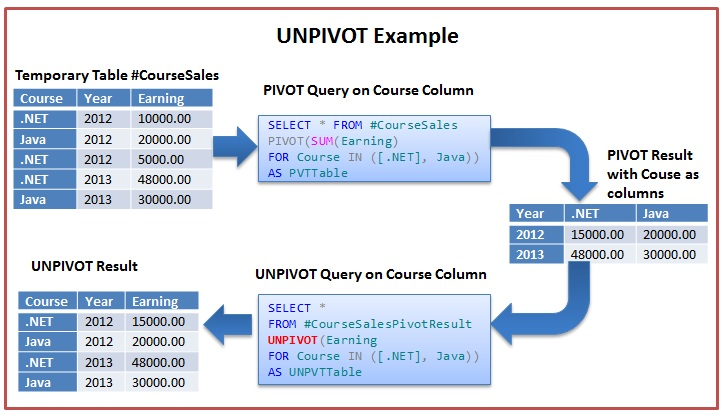

**LONG vs WIDE TABLES**

These two operations are essentialy a way to move among these 2 table presentations.

Wide table → many columns, categories as columns

Long table → few columns, categories as rows


This is often used on wide tables. A wide table usually has many columns and few rows,

having each month as column name, is an example of wide table.

UNPIVOT (Wide → Long)

PIVOT (Long → Wide)

Both of these, create new columns,

this is how they fit into order of sql statements.

1. FROM / JOIN
  - This is where the *PIVOT/UNPIVOT* operator executes
  - SQL reads the source table
  - Applies the pivot transformation
  - Produces a new virtual table

2. WHERE
3. GROUP BY
4. HAVING
5. SELECT
6. DISTINCT
7. ORDER BY
8. LIMIT/OFFSET

**ROW and COLUMN terminilogy**

Common mnemonic for operations is:

- PIVOT = rows → columns
- UNPIVOT = columns → rows

These should be seen in context of SQL, not Linear Algebra/Matrix,

where rows and columns are basically the same thing in opposite directions.

In Context of SQL:

- rows = data values
- columns = schema field


**1.) PIVOT**


*Rows become columns: a value from a row becomes a column name.*

A PIVOT turns row values into column names.

Take one column’s values → turn them into headers → fill the cells using an aggregate of another column.

A PIVOT operation:

  - Takes one column’s values and turns them into separate columns
    →  This is why we say *rows become columns*.
  - Performs an aggregation (SUM, COUNT, MAX, etc.) on another column
    → This is necessary because multiple rows might map to the same pivoted cell.

- Produces a new table where:
  - The pivot column becomes multiple columns
  - The aggregation column becomes the values inside those new columns


https://www.geeksforgeeks.org/sql/pivot-and-unpivot-in-sql/

```
SELECT (ColumnNames)
FROM (TableName)
PIVOT
 (
   AggregateFunction(ColumnToBeAggregated)
   FOR PivotColumn IN (PivotColumnValues)
 ) AS (Alias) //Alias is a temporary name for a table

```

Statement needs to have actual values that will appear inside IN defined.
Since column names must be known before the query runs,
these two workarounds are not possible

- Using wilcard inside IN (*) is not allowed
- Generating a with statement/subquery, that would read distinct values.


You can however, read values before programmatically and concantenate string of SQL statement,
that uses these values.

In [ ]:
df = pd.DataFrame({
    "employee": ["Alice", "Alice", "Bob", "Bob", "Charlie", "Charlie", "Bob", "Bob", "Charlie", "Charlie"],
    "month": ["Jan", "Feb", "Jan", "Feb", "Jan", "Feb", "Jan", "Feb", "Jan", "Feb"],
    "amount": [1200, 1500, 900, 1100, 700, 800, 100, 200, 300, 400],
})
df

,employee,month,amount
0,Alice,Jan,1200
1,Alice,Feb,1500
2,Bob,Jan,900
3,Bob,Feb,1100
4,Charlie,Jan,700
5,Charlie,Feb,800
6,Bob,Jan,100
7,Bob,Feb,200
8,Charlie,Jan,300
9,Charlie,Feb,400


In [ ]:
duckdb.sql("CREATE OR REPLACE TABLE emp_sales AS SELECT * FROM df")

In [ ]:
duckdb.sql("""
    SELECT *
    FROM emp_sales
    PIVOT (
        SUM(amount)
        FOR month IN ('Jan', 'Feb')
    ) AS sales
    ORDER BY employee
""").df()

,employee,Jan,Feb
0,Alice,1200.0,1500.0
1,Bob,1000.0,1300.0
2,Charlie,1000.0,1200.0


**Conditional aggregation**

Obtaining equivalent result without PIVOT,

by doing GROUP BY and AGGREGATION based on value.

Essentialy you do this for every value you plan to turn into column:

```
SUM(CASE WHEN column = 'value' THEN measure END) AS value
```

In [ ]:
duckdb.sql("""
  SELECT
      s.employee,
      SUM(CASE WHEN s.month = 'Jan' THEN s.amount END) AS Jan,
      SUM(CASE WHEN s.month = 'Feb' THEN s.amount END) AS Feb
  FROM emp_sales s
  GROUP BY s.employee
  ORDER BY s.employee
""").df()

,employee,Jan,Feb
0,Alice,1200.0,1500.0
1,Bob,1000.0,1300.0
2,Charlie,1000.0,1200.0


In [ ]:
duckdb.sql("""
    SELECT *
    FROM emp_sales
    LIMIT 2
""").df()

,employee,month,amount
0,Alice,Jan,1200
1,Alice,Feb,1500


We see that two columns disapeared because using PIVOT:

- The pivot column is used to create new columns.
- The aggregated column is used to fill those new column, becomes value of these columns.


They were used to calculate new columns and are "consumed"

All other columns not involved in the pivot or aggregation remain.

Original table can no longer be referenced by its name/alias,

but we can reference the columns via alias name created by PIVOT (AS statement),

alias can also be the same as name of the table.

In [ ]:
duckdb.sql("""
    SELECT sales_alias.employee, sales_alias.Jan, sales_alias.Feb
    FROM emp_sales
    PIVOT (
        SUM(amount)
        FOR month IN ('Jan', 'Feb')
    ) AS sales_alias
    ORDER BY employee
""").df()

,employee,Jan,Feb
0,Alice,1200.0,1500.0
1,Bob,1000.0,1300.0
2,Charlie,1000.0,1200.0


**COMBINING MULTIPLE PIVOT STATEMENTS**

You can always do multiple pivots,

cleanest pattern for multiple pivots in SQL is using WITH.

1.) Example of multiple PIVOT statements on 2 separate tables.

In [ ]:
df_sales = pd.DataFrame({
    "employee": ["Alice", "Alice", "Bob", "Bob"],
    "month": ["Jan", "Feb", "Jan", "Feb"],
    "sales": [100, 120, 90, 110]
})

df_expenses = pd.DataFrame({
    "employee": ["Alice", "Alice", "Bob", "Bob"],
    "category": ["Travel", "Food", "Travel", "Food"],
    "amount": [300, 150, 200, 100]
})

In [ ]:
duckdb.register("sales", df_sales)
duckdb.register("expenses", df_expenses)

We see that results of PIVOT operations are joined like normal tables via alias.

In [ ]:
query = """
WITH PivotSales AS (
    SELECT *
    FROM sales
    PIVOT (
        SUM(sales) FOR month IN ('Jan', 'Feb')
    )
),
PivotExpenses AS (
    SELECT *
    FROM expenses
    PIVOT (
        SUM(amount) FOR category IN ('Travel', 'Food')
    )
)
SELECT
    s.employee,
    s.Jan AS sales_jan,
    s.Feb AS sales_feb,
    e.Travel AS travel_expense,
    e.Food AS food_expense
FROM PivotSales s
JOIN PivotExpenses e USING (employee)
ORDER BY employee;
"""

duckdb.sql(query).df()


,employee,sales_jan,sales_feb,travel_expense,food_expense
0,Alice,100.0,120.0,300.0,150.0
1,Bob,90.0,110.0,200.0,100.0


2.) Example of chaining operation, PIVOTING of PIVOT result

In [ ]:
df = pd.DataFrame({
    "employee": ["Alice","Alice","Alice","Bob","Bob","Bob"],
    "month": ["Jan","Feb","Mar","Jan","Feb","Mar"],
    "category": ["Food","Food","Travel","Food","Travel","Travel"],
    "sales": [100,120,300,90,200,250]
})

In [ ]:
duckdb.sql("CREATE OR REPLACE TABLE t AS SELECT * FROM df")

You take output from query and run pivot again, creating new columns and losing pivoted and aggregated columns

In [ ]:
duckdb.sql("""
WITH P1 AS (
    SELECT *
    FROM t
    PIVOT (
        SUM(sales) FOR month IN ('Jan','Feb','Mar')
    ) AS p
),
P2 AS (
    SELECT *
    FROM P1
    PIVOT (
        SUM(Jan) FOR category IN ('Food','Travel')
    ) AS s
)
--- outputs of pivot are selected twice with renaming ---
SELECT p2.*, p2.Food AS JanFood, p2.Travel AS JanTravel
FROM P2
ORDER BY employee;
""").df()

,employee,Feb,Mar,Food,Travel,JanFood,JanTravel
0,Alice,NaN,300.0,NaN,NaN,NaN,NaN
1,Alice,120.0,NaN,100.0,NaN,100.0,NaN
2,Bob,200.0,250.0,NaN,NaN,NaN,NaN
3,Bob,NaN,NaN,90.0,NaN,90.0,NaN


Output of the intermediate operation after first PIVOT.

In [ ]:
duckdb.sql("""
WITH P1 AS (
    SELECT *
    FROM t
    PIVOT (
        SUM(sales) FOR month IN ('Jan','Feb','Mar')
    ) AS p
)
SELECT *
FROM P1
ORDER BY employee;
""").df()

,employee,category,Jan,Feb,Mar
0,Alice,Food,100.0,120.0,NaN
1,Alice,Travel,NaN,NaN,300.0
2,Bob,Food,90.0,NaN,NaN
3,Bob,Travel,NaN,200.0,250.0


**2.) UNPIVOT**

*Columns become rows: a column name becomes a row value*

An UNPIVOT turns columns back into row values.


Take several column names → turn them into row values → place the corresponding cell contents into a single value column.

UNPIVOT turns column names into row values.

- Take several columns → turn their names into values in a key column
- Take their cell values → place them into a single value column
- No aggregation is needed
- The table becomes longer (more rows), and the unpivoted columns disappear


```
SELECT (ColumnNames)
FROM (TableName)
UNPIVOT
(
  NewColumnForValue   FOR NewColumnForKey IN (UnpivotColumnValues)
) AS (Alias)
```

PIVOT → uses an aggregate function + values in IN()

UNPIVOT → uses a plain column name + column names in IN()

Or even shorter:

PIVOT = function + values → columns

UNPIVOT = column + columns → values

Why this difference exists
- Pivoting summarizes data → needs an aggregate
- Unpivoting reshapes data → no summary needed


If values that were unpivoted don't contain any nulls,

and you unpivoted N columns,

then you will get in final output N times the number of rows from before.


While UNPIVOT has such a rule, there is no comparable rule for PIVOT.

In [ ]:
grades = pd.DataFrame({
    "student": ["Alice", "Bob", "Charlie"],
    "math": [85, 78, 92],
    "science": [88, 74, 95],
    "history": [90, 82, 88],
})
grades

,student,math,science,history
0,Alice,85,88,90
1,Bob,78,74,82
2,Charlie,92,95,88


In [ ]:
duckdb.sql("""
    SELECT *
    FROM grades
    UNPIVOT (
        score FOR subject IN (math, science, history)
    )
""").df()

,student,subject,score
0,Alice,math,85
1,Alice,science,88
2,Alice,history,90
3,Bob,math,78
4,Bob,science,74
5,Bob,history,82
6,Charlie,math,92
7,Charlie,science,95
8,Charlie,history,88


What happens if you leave out column, that should be UNPIVOTED based on context, it remains as a value inside this column for newly created rows.

In [ ]:
duckdb.sql("""
    SELECT *
    FROM grades
    UNPIVOT (
        score FOR subject IN (math,  history)
    )
""").df()

,student,science,subject,score
0,Alice,88,math,85
1,Alice,88,history,90
2,Bob,74,math,78
3,Bob,74,history,82
4,Charlie,95,math,92
5,Charlie,95,history,88


**3.) REVERSIBILITY OF OPERATIONS**

While these operations are basically inverse of each other,

they are not always reversible, since certain data information could be lost during transformations.

**PIVOT reversibility**

In [ ]:
do_reversible_example = True

In [ ]:
df = pd.DataFrame({
    "id":   [1, 1, 1, 2, 2, 2],
    "month_sort": [1, 2, 3, 1, 2, 3],
    "month": ["Jan", "Feb", "Mar", "Jan", "Feb", "Mar"],
    "value": [10.0, 20.0, 30.0, 40.0, 50.0, 60.0],
})

if not do_reversible_example:
  df.loc[df['month'] == 'Mar', 'month'] = 'Jan'
  df.loc[df['month_sort'] == 3, 'month_sort'] = 1

df

,id,month_sort,month,value
0,1,1,Jan,10.0
1,1,2,Feb,20.0
2,1,3,Mar,30.0
3,2,1,Jan,40.0
4,2,2,Feb,50.0
5,2,3,Mar,60.0


In [ ]:
pivoted = duckdb.sql("""
    SELECT *
    FROM df
    PIVOT (
        SUM(value) FOR month IN ('Jan', 'Feb', 'Mar')
    )
    ORDER BY id, month_sort
""").df()

pivoted

,id,month_sort,Jan,Feb,Mar
0,1,1,10.0,NaN,NaN
1,1,2,NaN,20.0,NaN
2,1,3,NaN,NaN,30.0
3,2,1,40.0,NaN,NaN
4,2,2,NaN,50.0,NaN
5,2,3,NaN,NaN,60.0


In [ ]:
unpivoted = duckdb.sql("""
    SELECT *
    FROM pivoted
    UNPIVOT (
        value FOR month IN (Jan, Feb, Mar)
    )
    ORDER BY id, month_sort
""").df()

unpivoted

,id,month_sort,month,value
0,1,1,Jan,10.0
1,1,2,Feb,20.0
2,1,3,Mar,30.0
3,2,1,Jan,40.0
4,2,2,Feb,50.0
5,2,3,Mar,60.0


In [ ]:
df.equals(unpivoted)

True

Why this multi‑column example is reversible:

- Each pivoted cell comes from exactly one original row
- No duplicates per (id, month)
- No NULLs
- Aggregation (SUM) does not collapse data

You can also test this:

If every pivoted column has exactly one contributing row per group, the pivot is reversible.

In [ ]:
test_reversibility = duckdb.sql("""
  SELECT
      id,
      COUNT(Jan) AS Jan_count,
      COUNT(Feb) AS Feb_count,
      COUNT(Mar) AS Mar_count
  FROM pivoted
  GROUP BY id
""").df()

test_reversibility

,id,Jan_count,Feb_count,Mar_count
0,2,1,1,1
1,1,1,1,1


But using COUNT() inside a PIVOT operation, is not reversible unless every contributing value is 1 or 0, because:

COUNT() destroys the original values.